In [14]:
import numpy as np
from numpy.linalg import*
import matplotlib.pyplot as plt
from numpy import r_, exp, cos, sin, pi, zeros, ones, hanning, sqrt, log, floor, reshape, mean
from scipy import signal, interpolate
from numpy.fft import fft
from itertools import combinations
import math

def cross_corr(y1, y2):  
    if len(y1) != len(y2):
        raise ValueError('The lengths of the inputs should be the same.')

    y1_auto_corr = np.dot(y1, y1) / len(y1)
    y2_auto_corr = np.dot(y2, y2) / len(y1)
    corr = signal.correlate(y1, y2, mode='same')
    unbiased_sample_size = signal.correlate(np.ones(len(y1)), np.ones(len(y1)), mode='same')
    corr = corr / unbiased_sample_size / np.sqrt(y1_auto_corr * y2_auto_corr)
    shift = len(y1) // 2

    max_corr = np.max(corr)
    argmax_corr = np.argmax(corr)
    return max_corr, argmax_corr - shift

def LPF(order, fc, fs):
    nyq = 0.5*fs
    fc_norm=fc/nyq
    b,a = signal.butter(order, fc_norm, btype='low')
    return b,a

def BPF(order, fl, fh, fs):
    nyq = 0.5*fs
    low=fl/nyq
    high=fh/nyq
    b,a = signal.butter(order, [low, high], btype='band')
    return b,a

In [11]:
# data import
Settings = 2
User = 2
DevLoc_path = 'DevLoc'+str(Settings)+'.csv'   # location of devices where device contains 6 mics
DevLoc = np.genfromtxt(DevLoc_path, delimiter=',')
Mic = np.zeros((24000,6,8))
for i in range(8):
    Mic_path = 'user'+str(User)+'_setting'+str(Settings)+'/'+str(i+1)+'.csv'      # measured data from mic arrays
    Mic[:,:,i] = np.genfromtxt(Mic_path, delimiter=',')
    
    
print(Mic[:,:,5])
print(DevLoc.shape)


[[ 1.2207e-03  8.5449e-04  9.9182e-04  1.2360e-03  1.5106e-03  1.5106e-03]
 [ 1.5259e-03  9.6130e-04  8.6975e-04  1.6174e-03  1.6785e-03  2.0447e-03]
 [ 1.5106e-03  9.4604e-04  6.5613e-04  1.5259e-03  2.0142e-03  1.6022e-03]
 ...
 [-3.0518e-05 -6.5613e-04 -9.1553e-04 -7.1716e-04 -4.2725e-04 -1.3733e-04]
 [-4.5776e-04 -9.3079e-04 -9.6130e-04 -8.8501e-04 -7.1716e-04 -4.2725e-04]
 [-1.0834e-03 -9.1553e-04 -8.2397e-04 -1.0529e-03 -7.3242e-04 -5.9509e-04]]
(8, 2)


0
1
2
3
4
5
6
7
User Location:  [4.03028506 0.69921612]
Error[m] =  0.3023046961630821


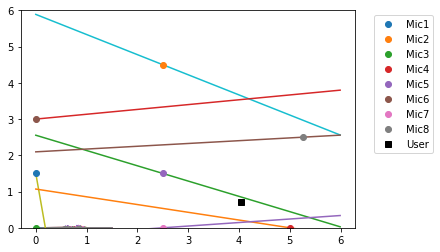

In [12]:
# Define parameters
vp = 330   # Propagation speed  [m/s]

Ns = len(Mic[:,0,0])    # Number of samples per single mic
fs = 16000  # [Hz]     # Sampled freq
ts = 1/fs  # Sampled time
t = np.arange(0,ts*Ns,ts)
freq = np.arange(0,fs,fs/Ns)
n = np.arange(0,Ns,1)
radius = 0.5*0.09218   # distance in meter from center of a single device.


r = np.zeros((6,2))   # Relative location of each microphone from device center
for i in range(6):
    r[i,0] = radius*cos((1-i)*pi/3)
    r[i,1] = radius*sin((1-i)*pi/3)



# Bandpass Filtering around 100Hz~2kHz

b,a = BPF(4,100,1500,fs)
w,h = signal.freqs(b,a)
for k in range(8):    
    for i in range(6):
        Mic[:,i,k] = signal.filtfilt(b,a,Mic[:,i,k])


# Let us interpolate the signal to oversample by Shrink_factor(SF) times.

SF = 5
n_new = np.arange(0,(Ns-1)+1/SF,1/SF)
Mic_new = np.zeros((len(n_new),6,8))

for k in range(8):
    for i in range(6):
        func = interpolate.interp1d(n,Mic[:,i,k])
        Mic_new[:,i,k]=func(n_new)
    

ts_new = ts/SF
Ns_new = len(Mic_new[:,0,0])
t_new = np.arange(0,ts_new*Ns_new,ts_new)




# Calculate relative time lag referenced to each microphone elements

# From relation: r_ij dot alpha = t_ij * vp. 
#comb = combinations([0,1,2,3,4,5],2)
r_ij = np.zeros((15,2))
dtau = np.zeros(15)
Vxy = np.zeros((2,8))
#for (i,j) in list(comb):
#    print(i,j)
lag_temp = np.zeros((15,8))

# [dtau]vp = [r_ref][X] where [X] is the direction vector toward the user U(x,y)
# Finding Least sqaure solution


for k in range(8):
    comb = combinations([0,1,2,3,4,5],2)
    print(k)
    q=0
    for (i,j) in list(comb):
        #print(i,j)
        r_ij[q] = r[i,:] - r[j,:]
        corr, lag = cross_corr(Mic_new[:,j,k], Mic_new[:,i,k])
        dtau[q] = lag*ts_new
        lag_temp[q,k]=lag

        q=q+1
    Vxy[:,k] = np.linalg.inv(r_ij.T@r_ij)@r_ij.T@dtau.T





flag=np.ones(8)
for i in range(8):
    #if np.max(np.square(Mic_new[:,0,i])) < 0.25 * np.max(np.square(Mic_new[:,0,:])):
    #    flag[i]=0
    #    continue
    flag[i]=np.average(np.square(Mic_new[:,0,i]))
    
    plt.plot(t_new, np.square(Mic_new[:,0,i]))
    #print(max(np.square(Mic_new[:,0,i])))
flag = flag/np.max(flag)

# Triangulation.  Assuming ax+by=c lines meet in one line is to solve least square problem.   [A] [Xu] = [C] 
A = Vxy.T[:,[1,0]]@[[1,0],[0,-1]]

# [C] = [beta,alpha] dot [DevLoc_x, DevLocy]
c = np.zeros(8)
for i in range(8):
    c[i] = A[i,:]@DevLoc[i,:]
#print(c)


#weights = [1,1,1,1,1,1,1,1]

weights = flag
W = np.diag(flag)
#print(W)

Uxy = np.linalg.inv(A.T@W@A)@A.T@W@c

########################################
#Plotting the graph 
x = np.arange(0,6,0.01)
y = np.zeros((len(x),8))

for i in range(8):
    if flag[i] == 0:
        y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
        plt.plot(x,y[:,i],':')
        continue
    if Vxy.T[i,1] == 0:
        plt.plot(1,-100)
        continue
    y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
    plt.plot(x,y[:,i])

plt.gca().set_prop_cycle(None)
for i in range(8):
    plt.plot(DevLoc[i,0],DevLoc[i,1],'o', label='Mic'+str(i+1))

#print(y.shape)

#print(Vxy.T)
plt.plot(Uxy[0],Uxy[1],'s', label='User', color='black')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.ylim([0,6])

print("User Location: ", Uxy)
if Settings==1:
    Error = np.linalg.norm(Uxy-[3,1])
if Settings==2:
    Error = np.linalg.norm(Uxy-[4,1])
    
print('Error[m] = ',Error)


User Location_new:  [4.03028506 0.69921612]
Error_new[m] =  0.3023046961630821


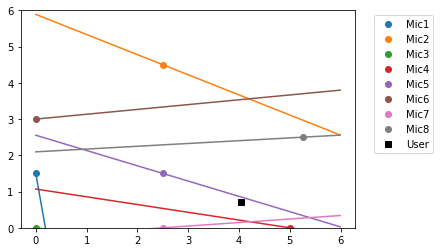

In [13]:
# Check the validity
Vxy_est = Uxy-DevLoc


for i in range(8):
    #print(Vxy_est[i,:]@Vxy[:,i])
    if Vxy_est[i,:]@Vxy[:,i] < 0:
        flag[i]=0


##############################################
# Repeat once
for k in range(8):
    comb = combinations([0,1,2,3,4,5],2)
    q=0
    for (i,j) in list(comb):

        r_ij[q] = r[i,:] - r[j,:]
        corr, lag = cross_corr(Mic_new[:,j,k], Mic_new[:,i,k])
        dtau[q] = lag*ts_new
        lag_temp[q,k]=lag
        q=q+1
    Vxy[:,k] = np.linalg.inv(r_ij.T@r_ij)@r_ij.T@dtau.T

# Triangulation.  Assuming ax+by=c lines meet in one line is to solve least square problem.   [A] [Xu] = [C] 
A = Vxy.T[:,[1,0]]@[[1,0],[0,-1]]
c = np.zeros(8)
for i in range(8):
    c[i] = A[i,:]@DevLoc[i,:]    

W = np.diag(flag)

Uxy = np.linalg.inv(A.T@W@A)@A.T@W@c
Vxy_est = Uxy-DevLoc

for i in range(8):
    if flag[i] == 0:
        y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
        plt.plot(x,y[:,i],':')
        continue
    if Vxy.T[i,1] == 0:
        plt.plot(1,-100)
        continue
    y[:,i] = (Vxy.T[i,1]/Vxy.T[i,0])*(x-DevLoc[i,0])+DevLoc[i,1]
    plt.plot(x,y[:,i])

plt.gca().set_prop_cycle(None)
for i in range(8):
    plt.plot(DevLoc[i,0],DevLoc[i,1],'o', label='Mic'+str(i+1))

plt.plot(Uxy[0],Uxy[1],'s', label='User', color='black')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

plt.ylim([0,6])

print("User Location_new: ", Uxy)
if Settings==1:
    Error = np.linalg.norm(Uxy-[3,1])
if Settings==2:
    Error = np.linalg.norm(Uxy-[4,1])
    
print('Error_new[m] = ',Error)